# Max likelihood

In [32]:
# imports
from importlib import reload

import pandas
import numpy as np
from scipy import special
import seaborn as sns
import mpmath
from matplotlib import pyplot as plt


# Generate a faux sample

## Let $E_{\rm max} = 10^{50}$ and $E_{\rm th} = 10^{40}$

In [2]:
gamma = -2.

In [3]:
NFRB = 100

In [5]:
lEmax = 50.
Emax = 10**lEmax

In [6]:
lEth = 40.
Eth = 10**lEth

In [9]:
norm = (Emax**(gamma+1) - Eth**(gamma+1))/(1+gamma)
norm

9.999999998999998e-41

In [8]:
randu = np.random.uniform(size=NFRB)

In [30]:
randE = (randu*(gamma+1)*norm + 10**(lEth*(gamma+1)))**(1/(1+gamma))

In [31]:
randE

array([1.14507870e+40, 1.22570665e+40, 1.22088525e+40, 1.89113617e+40,
       4.36140459e+40, 2.38788597e+40, 1.26837821e+40, 4.29231088e+40,
       1.96703791e+40, 4.50457126e+40, 2.51434189e+41, 1.16716677e+40,
       1.17363336e+40, 9.35984872e+40, 1.29442547e+40, 2.35942834e+40,
       1.02704916e+40, 1.14927448e+40, 2.03926087e+40, 1.21875233e+41,
       1.36021877e+40, 1.26214762e+40, 5.24133989e+40, 1.10974004e+40,
       2.82693720e+40, 3.99247071e+40, 1.91570597e+41, 1.16607900e+40,
       1.14092377e+40, 2.10329561e+40, 3.31006260e+40, 2.20876619e+40,
       2.14203669e+40, 2.16688823e+40, 3.83883374e+40, 1.43030650e+40,
       4.76438468e+40, 1.59768486e+40, 1.06334065e+40, 1.42382461e+40,
       1.05538392e+40, 1.16706179e+40, 3.26231711e+41, 1.72470599e+40,
       1.80477072e+41, 1.18154985e+40, 2.01192575e+40, 1.33723856e+40,
       4.43084396e+40, 1.06529245e+40, 1.08042214e+40, 1.66028048e+40,
       7.23171573e+40, 1.88385284e+40, 3.33098069e+40, 3.34478364e+40,
      

In [37]:
df = pandas.DataFrame()
df['E'] = randE
df['logE'] = np.log10(randE)

<AxesSubplot:xlabel='logE', ylabel='Count'>

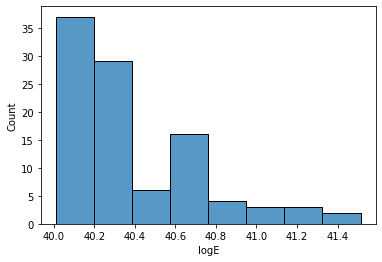

In [38]:
sns.histplot(data=df, x='logE')

# Max Likelihood Time!

## Methods

### We express the log-likelihood as 

## $\ln \mathcal{L} = - \int\limits_{E_{\rm th}}^{E_{\rm max}} p(E) dE + \sum\limits_{j=1}^N \ln p(E)$

### where $j$ is over all the $N$ FRBs and $p(E) = C E^\gamma$

## Likelihood terms

### This terms accounts for the total space explored.  It *decreases* with increasing Emax

In [83]:
def misses_term(C, Eth, Emax, gamma):
    return -C * (Emax**(gamma+1) - Eth**(gamma+1)) / (1+gamma)

### This term is simply proportional to the probability

In [50]:
def hit_term(Eval, C, gamma):
    NFRB = len(Eval)
    fterm = NFRB * np.log(C)
    sterm = gamma * np.sum(np.log(Eval))
    return fterm + sterm

In [51]:
def guess_C(gamma, Emax, Eth, NFRB):
    return NFRB * (gamma+1) / (Emax**(gamma+1) - Eth**(gamma+1))

## Test case $E_{max} = 10^{42}$

In [92]:
Emax = 1e42
Eth = 1e40

In [85]:
guessC = guess_C(gamma, Emax, Eth, NFRB)
guessC

1.00000010000001e+37

In [86]:
logC = np.log10(guessC)
Cvals = 10**(np.linspace(logC-1, logC+1, 1000))

In [87]:
LL_C = misses_term(Cvals, Eth, Emax, gamma) + hit_term(df.E, Cvals, gamma)

<AxesSubplot:>

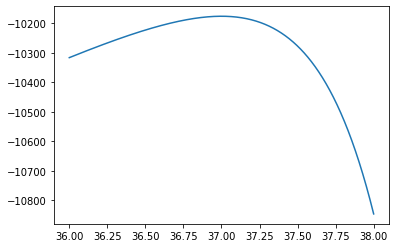

In [88]:
sns.lineplot(x=np.log10(Cvals), y=LL_C)

In [89]:
Cmax = Cvals[np.argmax(LL)]
Cmax

9.976978640061114e+36

## Loop a bit

In [90]:
LLs = []
Emaxs = 10**(np.linspace(42., 47., 100))

for Emax in Emaxs:
    guessC = guess_C(gamma, Emax, Eth, NFRB)
    logC = np.log10(guessC)
    Cvals = 10**(np.linspace(logC-1, logC+1, 1000))
    #
    LL_C = misses_term(Cvals, Eth, Emax, gamma) + hit_term(df.E, Cvals, gamma)
    #print(guessC, Cvals[np.argmax(LL_C)])
    LLs.append(np.max(LL_C))
LLs = np.array(LLs)

Text(0, 0.5, ' $\\Delta \\, LL$')

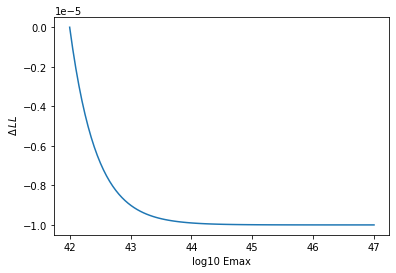

In [91]:
ax = sns.lineplot(x=np.log10(Emaxs), y=LLs - np.max(LLs))
ax.set_xlabel('log10 Emax')
ax.set_ylabel(r' $\Delta \, LL$')